# Can the model speak like trump ?

from chapter 10 fastbook.
and this very helpful kernel: from incredibly helpful notebook : https://www.kaggle.com/muellerzr/end-to-end-fastai2`

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/working


In [2]:
!pwd

/kaggle/working


In [3]:
path= '../input/donald-trumps-rallies'

In [4]:
from fastai.text.all import *

to have clarity over what path to use

In [5]:
!cp {path}/* '/kaggle/working'

In [6]:
path =Path('/kaggle/working')

In [7]:
path.ls()

(#36) [Path('/kaggle/working/Winston-SalemSep8_2020.txt'),Path('/kaggle/working/CharlestonFeb28_2020.txt'),Path('/kaggle/working/LexingtonNov4_2019.txt'),Path('/kaggle/working/MindenSep12_2020.txt'),Path('/kaggle/working/__notebook_source__.ipynb'),Path('/kaggle/working/WildwoodJan28_2020.txt'),Path('/kaggle/working/NewHampshireAug28_2020.txt'),Path('/kaggle/working/MosineeSep17_2020.txt'),Path('/kaggle/working/LasVegasFeb21_2020.txt'),Path('/kaggle/working/GreenvilleJul17_2019.txt')...]

### Language model

In [8]:
# help needed how to get this working

dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_text_files, splitter=RandomSplitter(0.1),
).dataloaders(path,path=path, bs=128, seq_len=80)

* Side note problem I had faced regarding the path:

checked here : https://docs.fast.ai/text.data

and here:
https://forums.fast.ai/t/oserror-errno-30-read-only-file-system/33216/4

finally put all the input files into /kaggle/working to avoid the read only error

In [9]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj well , i thank you very much . xxmaj so i want to start by saying , "" hello , xxmaj nevada . xxmaj how are you doing ? xxmaj how are you ? "" xxmaj and xxmaj i 'm thrilled to be in xxmaj douglas xxmaj county , but people are coming from all over the place . xxmaj there 's a lot of people for xxmaj douglas xxmaj county , is n't it ? xxmaj we","xxmaj well , i thank you very much . xxmaj so i want to start by saying , "" hello , xxmaj nevada . xxmaj how are you doing ? xxmaj how are you ? "" xxmaj and xxmaj i 'm thrilled to be in xxmaj douglas xxmaj county , but people are coming from all over the place . xxmaj there 's a lot of people for xxmaj douglas xxmaj county , is n't it ? xxmaj we have"
1,"so that 's gone a long way . xxmaj remember ? xxmaj remember when xxmaj donna xxmaj xxunk gave crooked xxmaj hillary the questions , right ? xxmaj to a debate ? xxmaj and then she said , "" well , i do n't think i did it . i do n't remember . "" i knew she was in trouble when she said , "" i do n't remember doing that . i do n't remember . "" xxmaj","that 's gone a long way . xxmaj remember ? xxmaj remember when xxmaj donna xxmaj xxunk gave crooked xxmaj hillary the questions , right ? xxmaj to a debate ? xxmaj and then she said , "" well , i do n't think i did it . i do n't remember . "" i knew she was in trouble when she said , "" i do n't remember doing that . i do n't remember . "" xxmaj she"


from incredibly helpful notebook : https://www.kaggle.com/muellerzr/end-to-end-fastai2

In [13]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, pretrained=True, metrics=[accuracy, Perplexity()]).to_fp16()

In [14]:
learn_lm.fine_tune(10, 4e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.105165,3.478579,0.332068,32.413624,00:19


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.770016,3.371909,0.339863,29.134094,00:22
1,3.657419,3.230865,0.352291,25.301546,00:22
2,3.524866,3.114485,0.366853,22.521830,00:22
3,3.394313,3.051332,0.374876,21.143478,00:23
4,3.299200,3.009461,0.381788,20.276472,00:22
5,3.212428,2.981365,0.384955,19.714712,00:22
6,3.162507,2.961790,0.388449,19.332548,00:22
7,3.127937,2.952478,0.390009,19.153360,00:22
8,3.103459,2.948696,0.390091,19.081059,00:22
9,3.088032,2.948236,0.390141,19.072275,00:22


In [16]:
learn_lm.save_encoder('fine_tuned')

### Spewing like trump

In [17]:
TEXT = 'My aim at this office is to '
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]

In [18]:
print('\n'.join(preds))

My xxunk at this office is to be kept in a state of emergency for the next 10 years , though the door will be used to be used for all of the programs . It was not until 4 November that it was confirmed
My xxunk at this office is to be written on the wall , where the Queen is , " You know you have a Queen . " Deputy Prime Minister Winston Churchill , who announced that Queen


In [23]:
def trumpsays(model, N_WORDS=40,N_SENTENCES=2, TEXT='My aim at this office is to '):
    preds = [model.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)]
    print('\n'.join(preds))

### There is scope for further improvement here

In [20]:
learn_lm.unfreeze()
learn.fit_one_cycle(10,2e-3)


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.423531,3.208445,0.360403,24.740593,00:23
1,3.219793,2.993608,0.389220,19.957563,00:23
2,2.998677,2.884475,0.402620,17.894171,00:22
3,2.789882,2.830922,0.412922,16.961094,00:23
4,2.592277,2.812565,0.418297,16.652578,00:23
5,2.409825,2.819306,0.418232,16.765213,00:22
6,2.247269,2.843642,0.416116,17.178219,00:23
7,2.111407,2.872154,0.415191,17.675049,00:22
8,2.004280,2.888974,0.415402,17.974857,00:23
9,1.942345,2.893999,0.415305,18.065414,00:23


In [24]:
trumpsays(learn_lm)

My xxunk at this office is to be a question about the US military . You 've had a problem , and you know why . It 's a good story . It 's so good . But it does n't work
My xxunk at this office is to say , " when you do n't sit back in the office , they do n't . " It 's true . If you have a president who is so badly there , he 's a highly respected


### Further improvements

Trying the ulm-fit method

SuggestedLRs(lr_min=6.918309954926372e-05, lr_steep=3.311311274956097e-06)

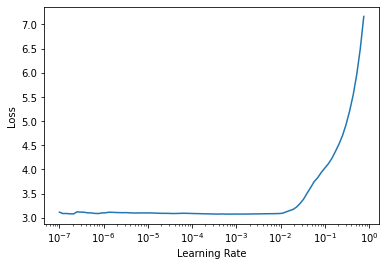

In [25]:
learn_lm.lr_find()



I don't actually know how to get exponential learning rate from this
any help would be good from comments

a resource to understand: https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

I feel like i should take 1e-5 here

In [26]:
# learn_lm.unfreeze()
# learn.fit_one_cycle(10,2e-3)


# trying more of this is actually bringing accuracy down

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.898909,2.910812,0.412682,18.371717,00:22
1,1.933789,2.934291,0.409441,18.808157,00:22
2,1.944722,2.966294,0.408161,19.419817,00:23
3,1.840609,3.030895,0.402460,20.715755,00:22
4,1.702062,3.096574,0.402427,22.122032,00:23
5,1.553674,3.181143,0.399514,24.074249,00:23
6,1.410617,3.246207,0.395461,25.692703,00:22
7,1.303711,3.295462,0.394598,26.989878,00:23
8,1.228340,3.329925,0.393359,27.936235,00:22
9,1.174179,3.333466,0.393731,28.035339,00:23


In [28]:
trumpsays(learn_lm, TEXT='I like Ashwin because')

i like Xxunk because they love me . They 're not happy . They love … They love me . They love me . But i love God . They love me . They love you
i like Xxunk because of that . He 's a smart guy who loves mine , and a great leader . He 's a warrior . He 's doing a great job , and she 's a great friend of mine


SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=9.12010818865383e-07)

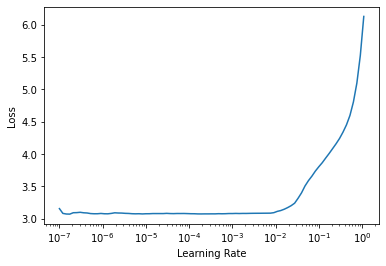

In [30]:
learn_lm.lr_find()

Ill take my chances with 1e-5

In [38]:
learn_lm.save('finetuned10')

Path('/kaggle/working/models/finetuned10.pth')

In [39]:
learn.load('finetuned10')

### trying ulmfit method 

again from muellerzr : https://www.kaggle.com/muellerzr/end-to-end-fastai2/comments

In [40]:
learn.to_fp16()

lr = 1e-5
moms = (0.8,0.7, 0.8)
lr *= learn_lm.dls.bs/128
learn.fit_one_cycle(1, lr, moms=moms, wd=0.1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.864325,2.948236,0.390141,19.072275,00:21


In [35]:
learn.freeze_to(-2)
lr/=2
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr), moms=moms, wd=0.1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.860599,2.947410,0.390515,19.056530,00:20


In [36]:
learn.freeze_to(-3)
lr /=2
learn.fit_one_cycle(1, slice(lr/(2.6**4), lr), moms=moms, wd=0.1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.865335,2.947410,0.390515,19.056530,00:20


In [37]:
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7,0.8), wd=0.1)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.859976,2.947410,0.390515,19.056530,00:20
1,2.863634,2.947410,0.390515,19.056530,00:20


In [41]:
trumpsays(learn, N_WORDS=100,N_SENTENCES=2, TEXT='We need to build a wall')

We need to build a wall , we have a building , we want it so much . We want to build it . We want to build a wall . It 's a wall . And i want to tell you
We need to build a wall , we have something to keep on going . We have a wall with the wall . We were building a wall under the United States Military in the last three years . They
We need to build a wall , we need the wall . We are building a wall , but you have a wall , and we want to rebuild it . We 're protecting , we 've done the wall . We will
We need to build a wall , we have to be able to build it , and we 're building a wall , and the wall is going to be so hard . What 's going on ? They have a wall .
We need to build a wall , because you know what we 're doing , you got to see that but some of the biggest people in the history of the world , we 've never seen anything like this . You do n't have
We need to build a wall , we want to keep it out of the wall and to use it . We will build a wall , which is happening in Israel .

its actually amazing how nice fastai library is.